In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from tqdm.notebook import tqdm_notebook as tqdm
import cv2
import skimage
from skimage.transform import resize
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.optimizers import Adam

In [2]:
SIZE_X = 128 
SIZE_Y = 128
SIZE_Z = 1
n_classes = 2 #Number of classes for segmentation

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
train_DF = pd.read_pickle(r"../../../Datasets/Dataset_A/aug_train_DF_{}.pkl".format(SIZE_X))
val_DF = pd.read_pickle(r"../../../Datasets/Dataset_A/aug_val_DF_{}.pkl".format(SIZE_X))
test_DF = pd.read_pickle(r"../../../Datasets/Dataset_A/aug_test_DF_{}.pkl".format(SIZE_X))

In [5]:
def normalize(img):
    plt.imsave('DR.png', img, cmap='gray')
    return cv2.imread('DR.png')[:, :, 0]

In [6]:
train_DF["Images"] = train_DF["Images"].apply(normalize)
val_DF["Images"] = val_DF["Images"].apply(normalize)
test_DF["Images"] = test_DF["Images"].apply(normalize)

In [7]:
classes_dict = {"Not Tumor": 0, "Tumor": 1}
# for index, row in train_DF.iterrows():
#     row["Tumor Mask"] = row["Tumor Mask"] * classes_dict[row["Labels"]]
    
# for index, row in val_DF.iterrows():
#     row["Tumor Mask"] = row["Tumor Mask"] * classes_dict[row["Labels"]]
    
# for index, row in test_DF.iterrows():
#     row["Tumor Mask"] = row["Tumor Mask"] * classes_dict[row["Labels"]]

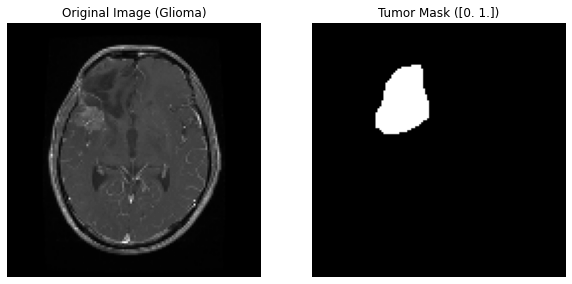

In [8]:
randInt = np.random.randint(0,len(train_DF))

# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 1
columns = 2

img  = train_DF.Images[randInt]
mask = train_DF["Tumor Mask"][randInt]


# Display Original Image
fig.add_subplot(rows, columns, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image ({})'.format(train_DF.Labels[randInt]))
plt.axis('off')
  
# Display Tumor Mask
fig.add_subplot(rows, columns, 2)
plt.imshow(mask, cmap='gray')
plt.title('Tumor Mask ({})'.format(np.unique(mask)))
plt.axis('off')
plt.show()

In [9]:
train_DF.head()

,PID,Images,Tumor Mask,Labels
0,101016,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Meningioma
1,100820,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Glioma
2,103670,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Pituitary
3,103671,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Pituitary
4,105374,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Meningioma


In [10]:
test_DF.head()

,PID,Images,Tumor Mask,Labels
0,106665,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Meningioma
1,108945,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Meningioma
2,MR051644C,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 3,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Glioma
3,106720,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Meningioma
4,97943,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Meningioma


In [11]:
y_train = train_DF["Tumor Mask"].tolist()
X_train = train_DF['Images'].tolist()
y_train = np.array(y_train).reshape(-1, SIZE_X, SIZE_Y)
X_train = np.array(X_train).reshape(-1, SIZE_X, SIZE_Y)


y_val = val_DF["Tumor Mask"].tolist()
X_val = val_DF['Images'].tolist()
y_val = np.array(y_val).reshape(-1, SIZE_X, SIZE_Y)
X_val = np.array(X_val).reshape(-1, SIZE_X, SIZE_Y)

y_test = test_DF["Tumor Mask"].tolist()
X_test = test_DF['Images'].tolist()
y_test = np.array(y_test).reshape(-1, SIZE_X, SIZE_Y)
X_test = np.array(X_test).reshape(-1, SIZE_X, SIZE_Y)


print("X_train shape:", X_train.shape," | y_train shape:", y_train.shape)
print("X_val shape  :",X_val.shape," | y_test shape : ", y_val.shape)
print("X_test shape :",X_test.shape," | y_test shape : ", y_test.shape)

X_train shape: (9192, 128, 128)  | y_train shape: (9192, 128, 128)
X_val shape  : (1224, 128, 128)  | y_test shape :  (1224, 128, 128)
X_test shape : (1840, 128, 128)  | y_test shape :  (1840, 128, 128)


In [12]:
y_train = np.expand_dims(y_train, axis=3)
X_train = np.expand_dims(X_train, axis=3)
X_train = X_train/255

y_val = np.expand_dims(y_val, axis=3)
X_val = np.expand_dims(X_val, axis=3)
X_val = X_val/255

y_test = np.expand_dims(y_test, axis=3)
X_test = np.expand_dims(X_test, axis=3)
X_test = X_test/255

print("X_train shape:", X_train.shape," | y_train shape:", y_train.shape)
print("X_val shape  :",X_val.shape," | y_test shape : ", y_val.shape)
print("X_test shape :",X_test.shape," | y_test shape : ", y_test.shape)

X_train shape: (9192, 128, 128, 1)  | y_train shape: (9192, 128, 128, 1)
X_val shape  : (1224, 128, 128, 1)  | y_test shape :  (1224, 128, 128, 1)
X_test shape : (1840, 128, 128, 1)  | y_test shape :  (1840, 128, 128, 1)


In [13]:
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=n_classes)
y_val_cat = to_categorical(y_val, num_classes=n_classes)
y_test_cat = to_categorical(y_test, num_classes=n_classes)

In [14]:
print("X_train shape:", X_train.shape,"| y_train shape:", y_train_cat.shape)
print("X_val shape:  ", X_val.shape,"| y_train shape: ", y_val_cat.shape)
print("X_test shape :",X_test.shape,"| y_test shape : ", y_test_cat.shape)

X_train shape: (9192, 128, 128, 1) | y_train shape: (9192, 128, 128, 2)
X_val shape:   (1224, 128, 128, 1) | y_train shape:  (1224, 128, 128, 2)
X_test shape : (1840, 128, 128, 1) | y_test shape :  (1840, 128, 128, 2)


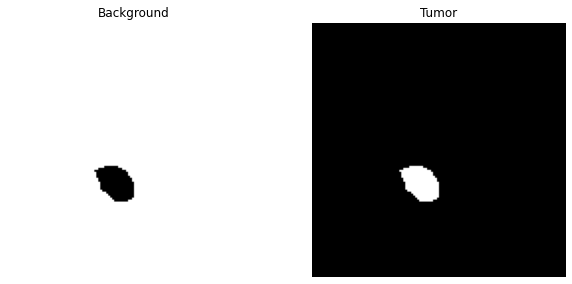

In [15]:
randInt = np.random.randint(len(y_test_cat))
mask = y_test_cat[randInt, :, :, :]
# create figure
fig = plt.figure(figsize=(10, 10))
  
# setting values to rows and column variables
rows = 1
columns = 2

images = []
titles = ["Background", "Tumor"]

# reading images
for i in range(n_classes):
    images.append(mask[:, :, i])

  
# Adds a subplot at the 1st position
for i in range(n_classes):
    fig.add_subplot(rows, columns, i+1)

    # showing image
    plt.imshow(images[i], 'gray')
    plt.axis('off')
    plt.title(titles[i])


In [16]:
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train),
                                                 y = labelencoder.fit_transform(y_train.reshape(-1,1).ravel()))
print("Class weights are...:", class_weights)


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

Class weights are...: [ 0.5085774  29.64634793]


In [17]:
np.save("class_weights.npy", class_weights)

In [18]:
import os
exp_num = []
if not os.path.exists("./experiments"):
    os.mkdir("./experiments")
folders = os.listdir("./experiments")
for folder in folders:
    exp_num.append(int(folder.split("#")[1]))


if len(exp_num) == 0:
    exp_path = r"./experiments/exp#1"
else:
    exp_path = r"./experiments/exp#"+str(max(exp_num)+1)




os.mkdir(exp_path)
os.mkdir(os.path.join(exp_path, "results"))
os.mkdir(os.path.join(exp_path, "weights"))

results = os.path.join(exp_path, "results")
weights = os.path.join(exp_path, "weights")

In [19]:
import segmentation_models as sm

activation='softmax'

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=class_weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)



metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

Segmentation Models: using `keras` framework.


In [20]:
sm.set_framework('tf.keras')
sm.framework()

# BACKBONE = ''
# preprocess_input = sm.get_preprocessing(BACKBONE)

# # preprocess input
# X_train = preprocess_input(X_train1)
# X_test = preprocess_input(X_test1)

# define model
model = sm.Unet(input_shape=(SIZE_X, SIZE_Y, SIZE_Z), classes=n_classes, activation=activation,  encoder_weights=None)

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics=metrics)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 64, 64, 64)   0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [21]:
from keras.callbacks import ModelCheckpoint


model_checkpoint_callback = ModelCheckpoint(
    filepath= os.path.join(weights, "best.h5"),
    verbose=100, 
    save_best_only=False, 
    mode='max')

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'loss val_accuracy', patience = 10)
    
history = model.fit(X_train, 
        y_train_cat, 
        batch_size = 16, 
        verbose=1, 
        epochs=60, 
        validation_data=(X_val, y_val_cat), 
        callbacks=[model_checkpoint_callback],
        shuffle=False)



Epoch 1/60
575/575 [==============================] - 50s 76ms/step - loss: -3.7593 - iou_score: 0.5749 - f1-score: 0.6525 - val_loss: -5.3464 - val_iou_score: 0.6310 - val_f1-score: 0.7093

Epoch 00001: saving model to ./experiments/exp#5\weights\best.h5
Epoch 2/60
575/575 [==============================] - 41s 71ms/step - loss: -7.6256 - iou_score: 0.6974 - f1-score: 0.7830 - val_loss: -7.9779 - val_iou_score: 0.7081 - val_f1-score: 0.7935

Epoch 00002: saving model to ./experiments/exp#5\weights\best.h5
Epoch 3/60
575/575 [==============================] - 41s 71ms/step - loss: -9.0512 - iou_score: 0.7468 - f1-score: 0.8300 - val_loss: -9.0768 - val_iou_score: 0.7466 - val_f1-score: 0.8297

Epoch 00003: saving model to ./experiments/exp#5\weights\best.h5
Epoch 4/60
575/575 [==============================] - 41s 71ms/step - loss: -9.8110 - iou_score: 0.7763 - f1-score: 0.8554 - val_loss: -9.6480 - val_iou_score: 0.7689 - val_f1-score: 0.8492

Epoch 00004: saving model to ./experiment


Epoch 00032: saving model to ./experiments/exp#5\weights\best.h5
Epoch 33/60
575/575 [==============================] - 39s 68ms/step - loss: -13.1844 - iou_score: 0.9430 - f1-score: 0.9697 - val_loss: -11.3000 - val_iou_score: 0.8414 - val_f1-score: 0.9053

Epoch 00033: saving model to ./experiments/exp#5\weights\best.h5
Epoch 34/60
575/575 [==============================] - 39s 68ms/step - loss: -13.2087 - iou_score: 0.9445 - f1-score: 0.9705 - val_loss: -11.3912 - val_iou_score: 0.8455 - val_f1-score: 0.9082

Epoch 00034: saving model to ./experiments/exp#5\weights\best.h5
Epoch 35/60
575/575 [==============================] - 39s 68ms/step - loss: -13.1925 - iou_score: 0.9434 - f1-score: 0.9699 - val_loss: -11.2722 - val_iou_score: 0.8401 - val_f1-score: 0.9043

Epoch 00035: saving model to ./experiments/exp#5\weights\best.h5
Epoch 36/60
575/575 [==============================] - 39s 69ms/step - loss: -13.2392 - iou_score: 0.9463 - f1-score: 0.9715 - val_loss: -11.3647 - val_iou_s

In [22]:
# acc = model.evaluate(X_test, y_test_cat)
# name = str(round(acc, 4))

In [23]:
# Save The Trained model along with it training history   
metrics = pd.DataFrame(history.history)
metrics.to_pickle(os.path.join(results, "metrics"+'.pkl'))
model.save(os.path.join(weights, "First_Mulit_UNet" + '.h5'))

In [24]:
pd.DataFrame(history.history)

,loss,iou_score,f1-score,val_loss,val_iou_score,val_f1-score
0,-3.759322,0.574914,0.652458,-5.346430,0.631029,0.709328
1,-7.625628,0.697437,0.782957,-7.977898,0.708073,0.793498
2,-9.051150,0.746797,0.830009,-9.076759,0.746638,0.829740
3,-9.811032,0.776318,0.855396,-9.647950,0.768874,0.849160
4,-10.371394,0.799767,0.874318,-10.028366,0.783220,0.861628
5,-10.735546,0.815877,0.886680,-9.767203,0.771725,0.852461
6,-11.036839,0.829563,0.896815,-10.430840,0.801534,0.875610
7,-11.276989,0.840792,0.904972,-10.614544,0.809707,0.882020
8,-11.511119,0.852182,0.912908,-10.787289,0.817590,0.887973
9,-11.677684,0.860334,0.918548,-10.611862,0.809085,0.881692


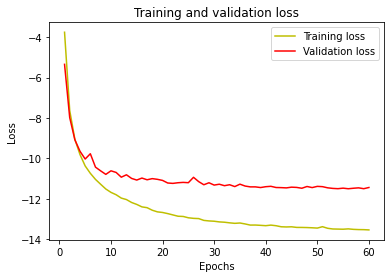

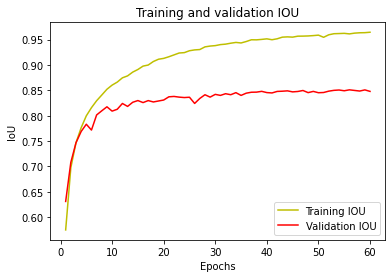

In [25]:
loss = metrics['loss']
val_loss = metrics['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig(os.path.join(results, 'loss_epoch.png'))
plt.legend()

plt.show()

acc = metrics['iou_score']
val_acc = metrics['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.savefig(os.path.join(results, 'IoU.png'))
plt.show()

In [26]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

##################################################

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.8396557


In [27]:
def prob_class(predicted_img, class_dic):
    rev_classes_dict = dict([(value, key) for key, value in class_dic.items()])
    result = ""
    if len(np.unique(predicted_img)) == 1:
        result = "(No Tumor)"
    else:
        for cls in np.unique(predicted_img):
            if cls != 0:
                prob = (predicted_img == cls).sum() / (0 != predicted_img).sum() 
                result += "({} {}%) ".format(rev_classes_dict[cls], str( round(prob*100, 2) ))

    return result

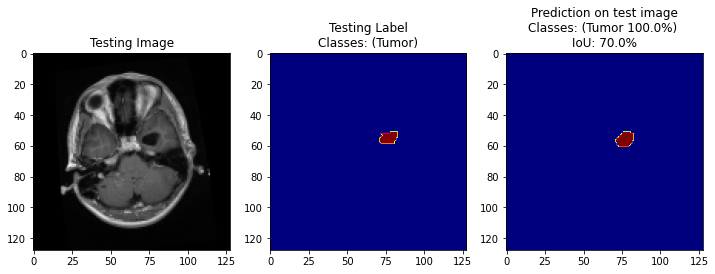

In [28]:
import random
test_img_number = random.randint(0, len(X_test))
rev_classes_dict = dict([(value, key) for key, value in classes_dict.items()])



test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]



intersection = np.logical_and(ground_truth[:,:,0], predicted_img)
union = np.logical_or(ground_truth[:,:,0], predicted_img)
iou_score = np.sum(intersection) / np.sum(union)

accuracy = str(round(iou_score * 100, 1))



plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')

plt.subplot(232)
plt.title('Testing Label\nClasses: ({})'.format(rev_classes_dict[np.unique(ground_truth)[1]]))
plt.imshow(ground_truth[:,:,0], cmap='jet')

plt.subplot(233)
plt.title('Prediction on test image\nClasses: {}\nIoU: {}%'.format(prob_class(predicted_img, classes_dict), accuracy))
plt.imshow(predicted_img, cmap='jet')
plt.savefig(os.path.join(results, 'loss_epoch.png'))
plt.show()